# **Stock Screener Project**

## Overview
This project automates the process of extracting, filtering, and analyzing financial data from multiple sources. It integrates with **Finviz**, **Financial Modeling Prep APIs**, and **Google Sheets** to create a dynamic and real-time stock screening tool. Notifications are sent via **Telegram**, making it a comprehensive tool for informed decision-making in the financial markets.

### Key features
1. Automated data extraction and cleaning
    - Stock data and key financial metrics are scraped directly from Finviz’s website 
2. Comprehensive financial metrics analysis
    - Detailed fundamental data is fetched through Financial Modeling Prep APIs
3. Filtered output stored in Google Sheets
4. Real-time notifications for actionable insights

---
## Investing Style
This screener adopts a **fundamental analysis** approach, focusing on the following investing styles:

- **Value Investing**: Identifies undervalued companies using metrics like low P/E and P/B ratios.
- **Quality Investing**: Highlights companies with strong earnings growth, low debt, and high ROIC.
- **Dividend Growth Investing**: Targets firms with a long history of consistent dividend payments, indicating financial stability and shareholder focus.

The idea is to look for large, well-known companies that are currently trading at bargain prices. By combining these strategies, the screener provides a robust framework for identifying long-term investment opportunities.


In [1]:
# --- Required Libraries ---
import requests
import pandas as pd
import time
import datetime
from bs4 import BeautifulSoup
from oauth2client.service_account import ServiceAccountCredentials
import gspread
import yfinance as yf
import time

In [2]:
# --- Config ---
from config import FMP_API, TOKEN, CHAT_ID, HEADERS
GOOGLE_CREDS_FILE = "credentials.json" 

## Setup

The following dates used later to run a `for` loop, not inclusive of the current year. 

- E.g. If we are currently in 2025, we want the 20-year loop to run from 2005 to 2024

In [3]:
# --- Setup ---
today = datetime.datetime.now().year
y20_date = today - 20
y10_date = today - 10

# --- Google Sheets Setup ---
scope = ["https://spreadsheets.google.com/feeds", "https://www.googleapis.com/auth/drive"]
creds = ServiceAccountCredentials.from_json_keyfile_name(GOOGLE_CREDS_FILE, scope)
client = gspread.authorize(creds)
spreadsheet = client.open("Stock Screener")
data_ws = spreadsheet.worksheet("Data")

## Finviz Function

The `get_finviz_data` function is designed to extract and aggregate stock data from the **Finviz** website. 

- **Purpose**: The function takes a URL as input, fetches the associated stock data, and compiles the results into a single DataFrame.

### Implementation:
1. The screener table is scraped from the url.
2. If multiple pages exists, the function will iterate through them. For each page, a new URL is constructed by appending the appropriate pagination parameter (`&r={p}`) to the original URL. The target table is then extracted and appended to the `tables` list.
3. All extracted tables are concatenated into a single DataFrame using `pd.concat`.




In [4]:
# --- Helper Function: Fetch Finviz data ---
def get_finviz_data(url):
    tables = []
    response = requests.get(url, headers=HEADERS)
    tables.append(pd.read_html(response.text)[-2])
    soup = BeautifulSoup(response.text, "html.parser")
    
    # get number of pages
    page_select = soup.find_all('select', {'id': 'pageSelect'})
    pages = int(page_select[-1].text.strip().split()[-1]) if page_select else 1
    
    # get tables from the other pages (if any)
    for p in range(21, 20 * pages, 20):
        paginated_url = f"{url}&r={p}"
        response = requests.get(paginated_url, headers=headers)
        tables.append(pd.read_html(response.text)[-2])

    return pd.concat(tables, ignore_index=True)

### Fetch Screener Data

This section of the project fetches stock screener data from Finviz using predefined URLs. Each URL represents a specific category of stocks based on market capitalization, valuation metrics, and technical performance.

#### Categories Overview

The following categories are used to filter stocks on Finviz:

1. **Market Capitalization**
   - **Mega Cap (`cap_mega`)**: Includes companies with the largest market capitalizations, exceeding 200 billion. These stocks are typically well-established and have lower risk due to their market dominance.
   - **Large Cap (`cap_large`)**: Covers companies with market capitalizations between 10 billion and 200 billion. These are stable companies with significant market presence.
2. **Valuation Metrics**
   - **Current Ratio (`fa_curratio_o1`)**: Filters for companies with a current ratio greater than 1, ensuring they have sufficient short-term assets to cover liabilities.
   - **Price-to-Book Ratio (`fa_pb_u3`)**: Targets stocks with P/B ratios under 3, indicating undervalued or fairly valued companies.
   - **Price-to-Earnings Ratio (`fa_pe_low`)**: Focuses on stocks with P/E ratios under 15, a common indicator of value investing.
3. **Technical Indicators**
   - **52-Week High/Low (`ta_highlow52w`)**: Filters stocks based on their price performance relative to their 52-week highs and lows, that potentially indicate value opportunities:
     - **`ta_highlow52w_nl`**: Stocks that have reached their 52-week low.
     - **`ta_highlow52w_a0to10h`**: Stocks trading within 0% to 10% of their 52-week low.
     - **`ta_highlow52w_b40h`**: Stocks trading at least 40% below their 52-week highs.
4. **Additional Criteria**
   - **Industry (`ind_stocksonly`)**: Limits the screener to individual stocks, excluding ETFs and other financial instruments.
   - **Sorting and Display Columns (`ft=4` & `c=0,1,2,...`)**: Configures the output to include relevant columns such as Ticker, Company, Sector, Market Cap, P/E, P/B, Dividend Yield, etc., and sorts results by Ticker.

---

#### Predefined Screener URLs

Each URL combines these filters to target specific types of stocks:

- **`MC_nl` (Mega Cap, New Low)**: Mega-cap stocks that have reached their 52-week lows.
- **`LC_nl` (Large Cap, New Low)**: Large-cap stocks that have reached their 52-week lows.
- **`MC_10low` (Mega Cap, 0-10% Above Low)**: Mega-cap stocks trading within 0-10% above their 52-week lows.
- **`LC_10low` (Large Cap, 0-10% Above Low)**: Large-cap stocks trading within 0-10% above their 52-week lows.
- **`MC_40high` (Mega Cap, 40% Below High)**: Mega-cap stocks trading at least 40% below their 52-week highs.
- **`LC_40high` (Large Cap, 40% Below High)**: Large-cap stocks trading at least 40% below their 52-week highs.

---

#### Purpose of Filters

By combining these fundamental and technical filters, the screener aims to:

- Identify **undervalued stocks** with strong financial stability.
- Highlight **growth opportunities** in large and mega-cap stocks.

In [5]:
# --- Fetch Screener Data ---
main_table = []
urls = {
    "MC_nl": "https://finviz.com/screener.ashx?v=152&f=cap_mega,fa_curratio_o1,"
             "fa_pb_u3,fa_pe_low,ind_stocksonly,ta_highlow52w_nl&ft=4&o=ticker&"
             "c=0,1,2,3,4,5,6,7,11,75,24,35,37,57,58,65",
    "LC_nl": "https://finviz.com/screener.ashx?v=152&f=cap_large,fa_curratio_o1,"
             "fa_pb_u3,fa_pe_low,ind_stocksonly,ta_highlow52w_nl&ft=4&o=ticker&"
             "c=0,1,2,3,4,5,6,7,11,75,24,35,37,57,58,65",
    "MC_10low": "https://finviz.com/screener.ashx?v=152&f=cap_mega,fa_curratio_o1,"
                "fa_pb_u3,fa_pe_low,ind_stocksonly,ta_highlow52w_a0to10h&ft=4&o=ticker&"
                "c=0,1,2,3,4,5,6,7,11,75,24,35,37,57,58,65",
    "LC_10low": "https://finviz.com/screener.ashx?v=152&f=cap_large,fa_curratio_o1,"
                "fa_pb_u3,fa_pe_low,ind_stocksonly,ta_highlow52w_a0to10h&ft=4&o=ticker&"
                "c=0,1,2,3,4,5,6,7,11,75,24,35,37,57,58,65",
    "MC_40high": "https://finviz.com/screener.ashx?v=152&f=cap_mega,fa_curratio_o1,"
                 "fa_pb_u3,fa_pe_low,ind_stocksonly,ta_highlow52w_b40h&ft=4&o=ticker&"
                 "c=0,1,2,3,4,5,6,7,11,75,24,35,37,57,58,65",
    "LC_40high": "https://finviz.com/screener.ashx?v=152&f=cap_large,fa_curratio_o1,"
                 "fa_pb_u3,fa_pe_low,ind_stocksonly,ta_highlow52w_b40h&ft=4&o=ticker&"
                 "c=0,1,2,3,4,5,6,7,11,75,24,35,37,57,58,65"
}

for label, url in urls.items():
    df = get_finviz_data(url)
    main_table.append(df)

### Clean Data

This section processes the raw data from the stock screener to prepare it for analysis. Key steps include:

1. **Remove empty tables.**
2. **Combine all tables into a single DataFrame.**
3. **Clean the Data:**
   - Remove unnecessary columns (e.g., "No.").
   - Exclude comapnies that do not pay dividends.
   - Drop columns with all missing values and remove any duplicate rows.
4. **Update Google Sheets:**
   - Clear existing data in the "Data" worksheet.
   - Upload the cleaned and formatted data.

In [6]:
# --- Clean Screener Data ---

main_table = [df for df in main_table if df.columns[-1] == 'Price']
df = pd.concat(main_table, ignore_index=True)

if df.columns[0] == "No.":
    df = df.drop(columns=df.columns[0])
df = df[df.Dividend != "-"]
df = df.dropna(axis=1, how='all')
df = df.drop_duplicates(keep="first", inplace=False)
df = df.reset_index(drop=True)

ticker_column_index = df.columns.get_loc('Ticker')
df = df.iloc[:, ticker_column_index:]
tickers = df["Ticker"].tolist()

spreadsheet = client.open("Stock Screener")
data_ws = spreadsheet.worksheet("Data")
spreadsheet.values_clear("Data!A2:AC100")
data_ws.update([df.columns.values.tolist()] + df.values.tolist())
print(df.head())

  Ticker                         Company             Sector  \
0   REGN  Regeneron Pharmaceuticals, Inc         Healthcare   
1    XOM                Exxon Mobil Corp             Energy   
2    CNC                    Centene Corp         Healthcare   
3    COP                 Conoco Phillips             Energy   
4    DHI                 D.R. Horton Inc  Consumer Cyclical   

                   Industry Country Market Cap    P/E   P/B Dividend  \
0             Biotechnology     USA     52.93B  12.48  1.81     2.83   
1      Oil & Gas Integrated     USA    440.88B  13.53  1.68      4.0   
2          Healthcare Plans     USA     28.08B   8.40  1.01     1.25   
3             Oil & Gas E&P     USA    107.75B  10.83  1.65     3.18   
4  Residential Construction     USA     36.27B   8.93  1.50     1.59   

  Outstanding  Curr R  LTDebt/Eq 52W High 52W Low   Price  
0     106.40M    4.93       0.09  -59.52%  -5.81%  490.28  
1       4.31B    1.24       0.12  -19.03%   4.60%  102.30  
2     49

## Income Statement Data

This section retrieves and integrates `revenue`, `reportedCurrency`, and `calendarYear` data for each stock using the **Financial Modeling Prep API**.

### Key Consideration:
- **Revenue as a Measure of Adequate Size**: While we do not filter companies strictly based on revenue, we prioritize those with **revenue exceeding $100 million** as an informal criterion for adequate size.

Including revenue data ensures we focus on companies that meet basic size requirements.


In [7]:
# --- Income Statement Data ---

rev_list = []
currency_list = []
year_list = []

for tick in tickers:
    data = requests.get(
        f"https://financialmodelingprep.com/api/v3/income-statement/{tick}?limit=1&apikey={FMP_API}"
    ).json()[0]
    rev_list.append(data["revenue"])
    currency_list.append(data["reportedCurrency"])
    year_list.append(data["calendarYear"])

df = df.assign(FY=year_list)
df = df.assign(Currency=currency_list)
df = df.assign(Revenue=rev_list)

df = df.reset_index(drop=True)
data_ws.update([df.columns.values.tolist()] + df.values.tolist())
print(df.head())

  Ticker                         Company             Sector  \
0   REGN  Regeneron Pharmaceuticals, Inc         Healthcare   
1    XOM                Exxon Mobil Corp             Energy   
2    CNC                    Centene Corp         Healthcare   
3    COP                 Conoco Phillips             Energy   
4    DHI                 D.R. Horton Inc  Consumer Cyclical   

                   Industry Country Market Cap    P/E   P/B Dividend  \
0             Biotechnology     USA     52.93B  12.48  1.81     2.83   
1      Oil & Gas Integrated     USA    440.88B  13.53  1.68      4.0   
2          Healthcare Plans     USA     28.08B   8.40  1.01     1.25   
3             Oil & Gas E&P     USA    107.75B  10.83  1.65     3.18   
4  Residential Construction     USA     36.27B   8.93  1.50     1.59   

  Outstanding  Curr R  LTDebt/Eq 52W High 52W Low   Price    FY Currency  \
0     106.40M    4.93       0.09  -59.52%  -5.81%  490.28  2024      USD   
1       4.31B    1.24       0.12  -1

## Balance Sheet Data

The section fetches key balance sheet metrics from the **Financial Modeling Prep API** for each stock ticker, including:

- **Current Assets** (`totalCurrentAssets`)
- **Total Assets** (`totalAssets`)
- **Current Liabilities** (`totalCurrentLiabilities`)
- **Long-Term Debt** (`longTermDebt`)

### Key Considerations:

- **Total Assets:** We pay attention to companies with total assets of at least **$50 million** as a rough measure of company size. However, this is used as an observational metric and is **not a strict filter**.

- **Long-Term Debt vs. Net Current Assets:** A strong financial condition is indicated when **long-term debt does not exceed net current assets** (also known as net working capital). This serves as a liquidity and solvency check, but again, it is **not applied as a hard filter**.

This approach allows flexible analysis while keeping an eye on financial health indicators without excluding potentially valuable stocks prematurely.


In [8]:
# --- Balance Sheet Data ---

CA_list = []
TA_list = []
CL_list = []
Debt_list = []

for tick in tickers:
    data = requests.get(
        f"https://financialmodelingprep.com/api/v3/balance-sheet-statement/{tick}?limit=1&apikey={FMP_API}"
    ).json()[0]
    CA_list.append(data["totalCurrentAssets"])
    TA_list.append(data["totalAssets"])
    CL_list.append(data["totalCurrentLiabilities"])
    Debt_list.append(data["longTermDebt"])

df = df.assign(Current_Assets=CA_list)
df = df.assign(Total_Assets=TA_list)
df = df.assign(Current_Liabilities=CL_list)
df = df.assign(LT_Debt=Debt_list)

df = df.reset_index(drop=True)
data_ws.update([df.columns.values.tolist()] + df.values.tolist())
print(df.head())

  Ticker                         Company             Sector  \
0   REGN  Regeneron Pharmaceuticals, Inc         Healthcare   
1    XOM                Exxon Mobil Corp             Energy   
2    CNC                    Centene Corp         Healthcare   
3    COP                 Conoco Phillips             Energy   
4    DHI                 D.R. Horton Inc  Consumer Cyclical   

                   Industry Country Market Cap    P/E   P/B Dividend  \
0             Biotechnology     USA     52.93B  12.48  1.81     2.83   
1      Oil & Gas Integrated     USA    440.88B  13.53  1.68      4.0   
2          Healthcare Plans     USA     28.08B   8.40  1.01     1.25   
3             Oil & Gas E&P     USA    107.75B  10.83  1.65     3.18   
4  Residential Construction     USA     36.27B   8.93  1.50     1.59   

  Outstanding  ...  52W High  52W Low   Price    FY  Currency       Revenue  \
0     106.40M  ...   -59.52%   -5.81%  490.28  2024       USD   14202000000   
1       4.31B  ...   -19.03%  

## Dividend Data

The section evaluates each stock's dividend payment history using **Yahoo Finance** to determine consistency and longevity of dividend payments. The following steps are performed:

1. **Data Extraction:**
   - Dividend data for each stock ticker is fetched using the `yfinance` library.
   - The number of years dividends were paid is counted from the `y20_date`.


2. **Calculation:**
   - Each year in which dividends were paid is tracked, ensuring no duplicates for a given year.
   - The count of dividend-paying years is added as a new column, `Dividend_Years`, in the dataframe.

### Key Consideration:

- **Consistent Dividend Payers:** Look for companies that have paid dividends in at least **15 of the past 20 years** as a measure of financial stability and shareholder value. Companies failing to meet this criterion are **filtered out** during the screening process later on.

This focus on dividend consistency helps prioritize established, reliable dividend payers, aligning with the goals of long-term investors.


In [9]:
# --- Dividend Data ---

dvd_list = []
for tick in tickers:
    current_ticker = yf.Ticker(tick)
    time.sleep(1)
    dvd_df = current_ticker.dividends

    dvd_years = []
    for year in range(y20_date, today):
        for row in dvd_df.items():
            if year == row[0].year and year not in dvd_years:
                dvd_years.append(year)

    dvd_list.append(len(dvd_years))

df = df.assign(Dividend_Years=dvd_list)

df = df.reset_index(drop=True)
data_ws.update([df.columns.values.tolist()] + df.values.tolist())
print(df.head())

  Ticker                         Company             Sector  \
0   REGN  Regeneron Pharmaceuticals, Inc         Healthcare   
1    XOM                Exxon Mobil Corp             Energy   
2    CNC                    Centene Corp         Healthcare   
3    COP                 Conoco Phillips             Energy   
4    DHI                 D.R. Horton Inc  Consumer Cyclical   

                   Industry Country Market Cap    P/E   P/B Dividend  \
0             Biotechnology     USA     52.93B  12.48  1.81     2.83   
1      Oil & Gas Integrated     USA    440.88B  13.53  1.68      4.0   
2          Healthcare Plans     USA     28.08B   8.40  1.01     1.25   
3             Oil & Gas E&P     USA    107.75B  10.83  1.65     3.18   
4  Residential Construction     USA     36.27B   8.93  1.50     1.59   

  Outstanding  ...  52W Low   Price    FY Currency       Revenue  \
0     106.40M  ...   -5.81%  490.28  2024      USD   14202000000   
1       4.31B  ...    4.60%  102.30  2024      USD  

## EPS Data

This section analyzes the **earnings stability** and **growth** of each stock using historical earnings data fetched from the **Financial Modeling Prep API**. It calculates key metrics to assess financial performance over the past 10 years. The following steps are performed:

1. **Data Extraction:** Annual EPS for each stock are calculated from the `y10_date`.

2. **Earnings Stability:** Checks if EPS values are **positive for all 10 years**. A "Yes" or "No" value is stored in the column `Last_10_EPS_allpos`.

3. **Earnings Growth:**
    - **First 3-Year Average EPS:** Average EPS for the first three years is calculated and stored in the column `First_three_avgEPS`.
    - **Last 3-Year Average EPS:** Average EPS for the last three years is calculated and stored in the column `Last_three_avgEPS`.
    - Earnings growth is assessed by comparing the last 3-year average EPS to the first 3-year average EPS.

### Key Considerations:

- **Earnings Stability:** Stocks with **positive EPS for all 10 years** are preferred as an indicator of consistent profitability.

- **Earnings Growth:** Companies must exhibit **at least 25% growth** in the last 3-year average EPS compared to the first 3-year average EPS. This reflects improving profitability.

- **Valuation Check:** The **Price-to-Earnings Ratio** (P/E) is evaluated by comparing the current stock price to the last 3-year average EPS. Companies with a **P/E ratio greater than 15** are filtered out to ensure reasonable valuations.

These filters are applied later on and help identify companies with a track record of stable and growing earnings, aligning with principles of value and growth investing.


In [10]:
# --- EPS Data ---

is_all_pos = []
first_three_avg_eps = []
last_three_avg_eps = []

for tick in tickers:
    data = requests.get(f"https://financialmodelingprep.com/api/v3/earnings-surprises/{tick}?apikey={FMP_API}").json()

    eps_list = []
    for year in range(y10_date, today):
        total = 0

        for item in reversed(data):
            if str(year) == item["date"][0:4]:
                total += item["actualEarningResult"]

        eps_list.append(total)

    if all([val > 0 for val in eps_list]):
        is_all_pos.append("Yes")
    else:
        is_all_pos.append("No")

    first_three_avg_eps.append(sum(eps_list[:3]) / 3)
    last_three_avg_eps.append(sum(eps_list[-3:]) / 3)

df = df.assign(Last_10_EPS_allpos=is_all_pos)
df = df.assign(First_three_avgEPS=first_three_avg_eps)
df = df.assign(Last_three_avgEPS=last_three_avg_eps)

df = df.reset_index(drop=True)
data_ws.update([df.columns.values.tolist()] + df.values.tolist())
print(df.head())

  Ticker                         Company             Sector  \
0   REGN  Regeneron Pharmaceuticals, Inc         Healthcare   
1    XOM                Exxon Mobil Corp             Energy   
2    CNC                    Centene Corp         Healthcare   
3    COP                 Conoco Phillips             Energy   
4    DHI                 D.R. Horton Inc  Consumer Cyclical   

                   Industry Country Market Cap    P/E   P/B Dividend  \
0             Biotechnology     USA     52.93B  12.48  1.81     2.83   
1      Oil & Gas Integrated     USA    440.88B  13.53  1.68      4.0   
2          Healthcare Plans     USA     28.08B   8.40  1.01     1.25   
3             Oil & Gas E&P     USA    107.75B  10.83  1.65     3.18   
4  Residential Construction     USA     36.27B   8.93  1.50     1.59   

  Outstanding  ...  Currency       Revenue Current_Assets  Total_Assets  \
0     106.40M  ...       USD   14202000000    18660900000   37759400000   
1       4.31B  ...       USD  33924700

## ROIC (Return on Invested Capital) and NCAV (Net Current Asset Value) Data

This section calculates key financial metrics, **ROIC** and **NCAV**, for each stock using data fetched from the **Financial Modeling Prep API**. These metrics provide insights into capital efficiency and balance sheet strength.

- Note: NCAV is similar to working capital, but instead of subtracting current liabilities from current assets, total liabilities and preferred stock are subtracted.

### Key Considerations:

- **Price-to-NCAVPS:** Stocks where the current price is less than NCAVPS are noted as **not desirable** since they may indicate underlying issues or undervaluation for a reason. However, this is observed rather than explicitly filtered.  

- **ROIC Benchmarks**
    - Companies with a **ROIC of at least 6%** are considered acceptable.
    - A **ROIC of 10% or higher** is ideal, reflecting strong capital efficiency and profitability.
    - These thresholds are used as observational metrics but are **not applied as strict filters**.

In [11]:
# --- ROIC and NCAV Data ---

roic_list = []
NCAV_list = []

for tick in tickers:
    data = requests.get(
        f"https://financialmodelingprep.com/api/v3/key-metrics/{tick}?limit=1&apikey={FMP_API}"
    ).json()[0]
    roic = data.get("roic")
    NCAV = data.get("netCurrentAssetValue")

    roic_list.append(round(roic, 5) if roic is not None else 0)
    NCAV_list.append(round(NCAV, 5) if NCAV is not None else 0)

df = df.assign(ROIC=roic_list)
df = df.assign(NCAV=NCAV_list)

data_ws.update([df.columns.values.tolist()] + df.values.tolist())
print(df.head())

  Ticker                         Company             Sector  \
0   REGN  Regeneron Pharmaceuticals, Inc         Healthcare   
1    XOM                Exxon Mobil Corp             Energy   
2    CNC                    Centene Corp         Healthcare   
3    COP                 Conoco Phillips             Energy   
4    DHI                 D.R. Horton Inc  Consumer Cyclical   

                   Industry Country Market Cap    P/E   P/B Dividend  \
0             Biotechnology     USA     52.93B  12.48  1.81     2.83   
1      Oil & Gas Integrated     USA    440.88B  13.53  1.68      4.0   
2          Healthcare Plans     USA     28.08B   8.40  1.01     1.25   
3             Oil & Gas E&P     USA    107.75B  10.83  1.65     3.18   
4  Residential Construction     USA     36.27B   8.93  1.50     1.59   

  Outstanding  ...  Current_Assets  Total_Assets Current_Liabilities  \
0     106.40M  ...     18660900000   37759400000          3944300000   
1       4.31B  ...     91990000000  45347500

## Key Metrics

The following criteria will be applied to identify high-quality stocks for further analysis:

1. **Dividend Consistency**:
   - Stocks must have a dividend payment history of **15 or more years**, indicating financial stability and shareholder focus.
2. **Earnings Stability**:
   - Only stocks with **positive earnings per share (EPS)** for the each of the last 10 years are considered.
3. **Low Debt**:
   - The **long-term debt-to-equity ratio** must be **2 or less**, ensuring manageable leverage levels.
4. **Reasonable Valuation**:
   - The product of the **price-to-earnings (P/E) ratio** and **price-to-book (P/B) ratio** should not exceed **25**, reflecting a focus on value investing principles.
   - The stock price relative to the average EPS over the last three years should not exceed **15**, highlighting reasonably priced stocks with sustainable earnings.
5. **Earnings Growth**:
   - The average EPS over the last three years must show a growth of at least 25% compared to the average EPS from the first three years of the 10-year period, indicating strong earnings momentum.

These metrics collectively ensure a focus on financially stable, undervalued, and growth-oriented companies.

In [12]:
# --- Filter Results ---

df["LTDebt/Eq"] = df["LTDebt/Eq"].astype(float)
df["P/E"] = df["P/E"].astype(float)
df["P/B"] = df["P/B"].astype(float)
df["Last_three_avgEPS"] = df["Last_three_avgEPS"].astype(float)
df["First_three_avgEPS"] = df["First_three_avgEPS"].astype(float)
df["Price"] = df["Price"].astype(float)

df = df[(df['Dividend_Years'] >= 15)
        & (df["Last_10_EPS_allpos"] == "Yes")
        & (df["LTDebt/Eq"] <= 2)
        & (df["P/E"] * df["P/B"] <= 25)
        & (((df["Last_three_avgEPS"] - df["First_three_avgEPS"]) /
            df["First_three_avgEPS"]) >= 0.25)
        & (df["Price"] / df["Last_three_avgEPS"] <= 15)]

df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df = df.sort_values(by="Ticker", ascending=True)  # Sort A-Z
df = df.reset_index(drop=True)

spreadsheet.values_clear("Filtered Data!A2:AC100")
filtered_ws = spreadsheet.worksheet("Filtered Data")
filtered_ws.update([df.columns.values.tolist()] + df.values.tolist())
print(df.head())

  Ticker           Company             Sector                        Industry  \
0    DHI   D.R. Horton Inc  Consumer Cyclical        Residential Construction   
1    HAL    Halliburton Co             Energy  Oil & Gas Equipment & Services   
2    LEN       Lennar Corp  Consumer Cyclical        Residential Construction   
3    XOM  Exxon Mobil Corp             Energy            Oil & Gas Integrated   

  Country Market Cap    P/E   P/B Dividend Outstanding  ...  Current_Assets  \
0     USA     36.27B   8.93  1.50     1.59     308.63M  ...     34745900000   
1     USA     16.84B   8.21  1.63     0.69     861.00M  ...     12382000000   
2     USA     27.83B   7.72  1.23     2.00     232.18M  ...     29307463000   
3     USA    440.88B  13.53  1.68      4.0       4.31B  ...     91990000000   

   Total_Assets Current_Liabilities      LT_Debt  Dividend_Years  \
0   36104300000          3590800000   4986400000              19   
1   25587000000          6050000000   7958000000              

## Telegram Alert

To ensure timely delivery of actionable insights, the project integrates with the **Telegram Bot API** to send alerts about screened stocks. These alerts summarize key details about each company and are delivered directly to a specified Telegram chat.  

In [13]:
# --- Send alerts through Telegram ---

ticker_list = df["Ticker"].tolist()
company_list = df["Company"].tolist()
sector_list = df["Sector"].tolist()
industry_list = df["Industry"].tolist()
country_list = df["Country"].tolist()

main_dic = {}

for item in range(1, len(ticker_list) + 1):
    dic = {
        item: {
            "Company": company_list[item - 1],
            "Ticker": ticker_list[item - 1],
            "Sector": sector_list[item - 1],
            "Industry": industry_list[item - 1],
            "Country": country_list[item - 1]
        }
    }
    main_dic.update(dic)

today = datetime.date.today() + datetime.timedelta(days=1)

for item in main_dic:
    message = (f"\n\n{item}) {main_dic[item]['Company']}\nTicker: {main_dic[item]['Ticker']}"
               f"\nSector: {main_dic[item]['Sector']}\nIndustry: {main_dic[item]['Industry']}"
               f"\nCountry: {main_dic[item]['Country']}")
    url = f"https://api.telegram.org/bot{TOKEN}/sendMessage?chat_id={CHAT_ID}&text={message}"
    requests.get(url)

## Conclusion

This project integrates multiple financial data sources, applies rigorous screening criteria, and delivers real-time insights to aid investment decisions. Key accomplishments include:  

- Automating the extraction and analysis of financial data using **web scraping** and **APIs**.
- Employing data manipulation and visualization techniques to derive actionable metrics.
- Utilizing **Google Sheets** for data storage and collaboration.
- Implementing a **Telegram alert system** for timely communication of opportunities.

The tool offers a comprehensive framework for financial analysis, combining technical skills and domain knowledge. It demonstrates expertise in areas like **automation**, and **financial analysis**, making it a valuable asset for any financial analyst role.  

### Sample Google Sheet Output

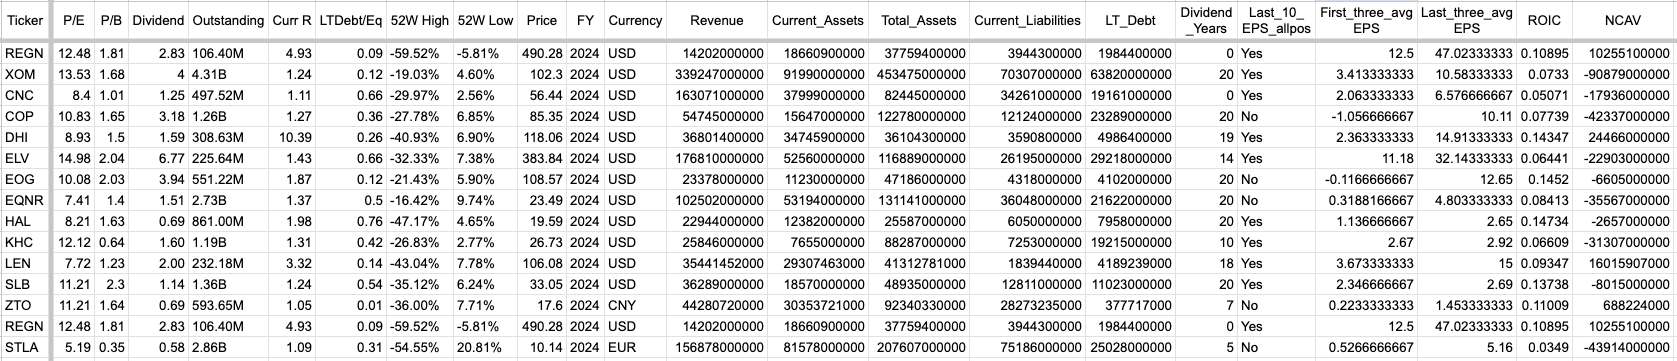

### Sample Telegram Output

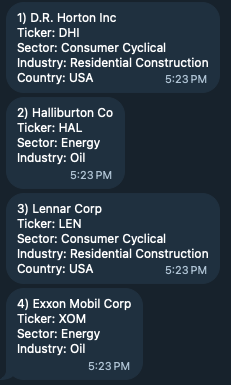